In [7]:
from netCDF4 import Dataset
import cmocean.cm as cmo
import numpy as np
import salem
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

In [8]:
usgs_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/usgs_1h/wrfout_test')
wur_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_1h/wrfout_test')
wur_lcz_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz_1h/wrfout_test')
modis_file = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/modis_lcz_1h/wrfout_test')

usgs_file

<xarray.Dataset> Size: 3GB
Dimensions:                (south_north: 165, west_east: 220, time: 16,
                            bottom_top: 60, soil_layers: 3, seed_dim: 7)
Coordinates:
    lat                    (south_north, west_east) float32 145kB 52.29 ... 5...
    lon                    (south_north, west_east) float32 145kB 4.728 ... 5...
    xtime                  (time) datetime64[ns] 128B ...
  * time                   (time) datetime64[ns] 128B 2019-07-23T06:00:00 ......
  * west_east              (west_east) float64 2kB -8.411e+04 ... -6.221e+04
  * south_north            (south_north) float64 1kB 3.535e+04 ... 5.175e+04
Dimensions without coordinates: bottom_top, soil_layers, seed_dim
Data variables: (12/211)
    LU_INDEX               (time, south_north, west_east) float32 2MB ...
    ZNU                    (time, bottom_top) float32 4kB ...
    ZNW                    (time, bottom_top) float32 4kB ...
    ZS                     (time, soil_layers) float32 192B ...
    DZS                    (time, soil_layers) float32 192B ...
    VAR_SSO                (time, south_north, west_east) float32 2MB ...
    ...                     ...
    PRESSURE               (time, bottom_top, south_north, west_east) float32 139MB ...
    GEOPOTENTIAL           (time, bottom_top, south_north, west_east) float32 139MB ...
    Z                      (time, bottom_top, south_north, west_east) float32 139MB ...
    SLP                    (time, south_north, west_east) float32 2MB ...
    PRCP_NC                (time, south_north, west_east) float32 2MB ...
    PRCP_C                 (time, south_north, west_east) float32 2MB ...
Attributes: (12/137)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2019-07-23_06:00:00
    SIMULATION_START_DATE:           2019-07-23_06:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      166
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=lcc +lat_0=51.9647178649902 +lon_0...

In [9]:
usgs_luindex = usgs_file.LU_INDEX.isel(time=5)
wur_luindex = wur_file.LU_INDEX.isel(time=5)
wur_lcz_luindex = wur_lcz_file.LU_INDEX.isel(time=5)
modis_luindex = modis_file.LU_INDEX.isel(time=5)

In [10]:
c_modis = [
    [0.43, 0.89, 1.0],
    [0.67, 0.94, 1.0],
    [1.0, 0.77, 0.89],
    [1.0, 0.6, 0.8],
    [1.0, 0.0, 1.0],
    [0.50, 0.0, 0.50],
    [0.0, 0.0, 0.50],
    [0.27, 0.27, 1.0],
    [0.2, 0.4, 1.0],
    [0.52, 0.64, 1.0],
    [1.0, 1.0, 1.0],  # URBAN IN ORIGINAL FILE
    [0.8, 0.8, 0.8],
    [0.70, 0.70, 0.70],
    [0.0, 0.0, 0.0],
    [0.6, 0.6, 0.6],
    [0.35, 0.35, 0.35],
    [0.50, 0.50, 0.0],
    [0.0, 0.36, 0.0],
    [0.0, 0.50, 0.0],
    [0.2, 0.6, 0.4],
    [0.62, 0.84, 0.0],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.83, 1.0, 0.35],
    [1.0, 1.0, 0.0],
    [1.0, 0.72, 0.44],
    [1.0, 0.6, 0.0],
    [1.0, 0.4, 0.0],
    [1.0, 0.0, 0.0],
    [0.64, 0.44, 1.0],
    [0.74, 0.29, 0.0],
    [0.67, 0.0, 0.22],
    [0.52, 0.0, 0.0],
]

c_usgs = np.array([
    [1,0,0],          #  1 Urban and Built-up Land
    [1,1,0],          #! 2 Dryland Cropland and Pasture
    [1,1,.2],         #  3 Irrigated Cropland and Pasture
    [1,1,.3],         #  4 Mixed Dryland/Irrigated Cropland and Pasture
    [.7,.9,.3],       #  5 Cropland/Grassland Mosaic
    [.7,.9,.3],       #  6 Cropland/Woodland Mosaic
    [0,1,0],          #  7 Grassland
    [.3,.7,0],        #  8 Shrubland
    [.82,.41,.12],    #  9 Mixed Shrubland/Grassland
    [1,.84,.0],       #  10 Savanna
    [.2,.8,.4],       #  11 Deciduous Broadleaf Forest
    [.2,.8,.2],       #  12 Deciduous Needleleaf Forest
    [0,.4,.2],        #  13 Evergreen Broadleaf Forest
    [0,.4,0],         #! 14 Evergreen Needleleaf Forest 
    [.2,.6,.2],       #  15 Mixed Forests
    [0,0,.88],        #  16 Water Bodies
    [0,1,1],          #! 17 Herbaceous Wetlands
    [.2,1,1],         #  18 Wooden Wetlands
    [.914,.914,.7],   #  19 Barren or Sparsely Vegetated
    [.86,.08,.23],    #  20 Herbaceous Tundraa
    [.86,.08,.23],    #  21 Wooded Tundra
    [.97,.5,.31],     #! 22 Mixed Tundra
    [.91,.59,.48],   #! 23 Barren Tundra
    [1,1,1]          #! 24 Snow and Ice
    ])



cmap = LinearSegmentedColormap.from_list('luse', c_usgs, N=24)
levels = np.arange(0, 24)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cmap2 = LinearSegmentedColormap.from_list('luse', c_modis, N=61)
levels2 = np.arange(0, 61)
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

In [11]:
ax_options = {
    'color': 'black',
    'linestyle': 'dotted',
    'linewidth': 0.5,
    'zorder': 103,
    'draw_labels': True,
    'x_inline': False,
    'y_inline': False,
}
title_options = {
    'loc': 'left',
    'fontsize': 'x-large',
    'fontweight': 'bold',
}
proj = ccrs.PlateCarree()
extent = [usgs_luindex.lon.min(), usgs_luindex.lon.max(), usgs_luindex.lat.min(), usgs_luindex.lat.max()]

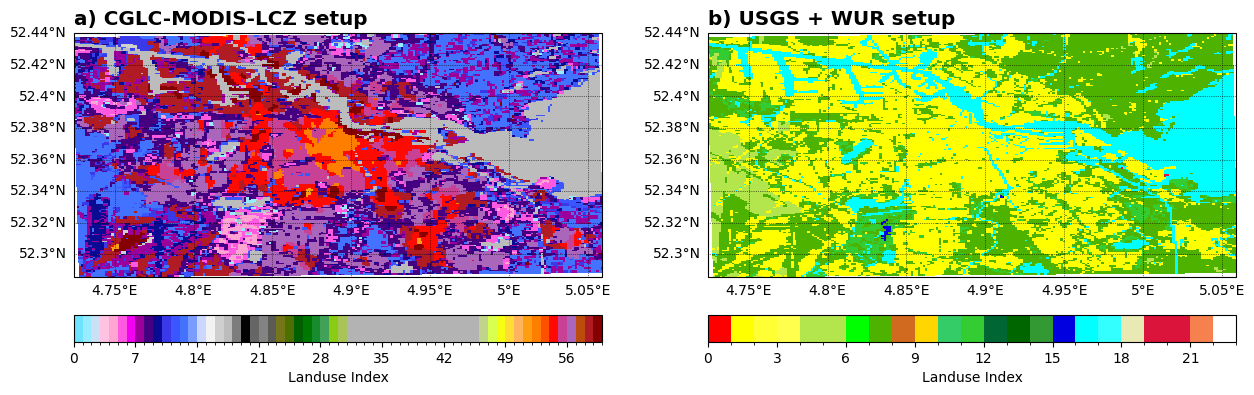

In [12]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    modis_luindex.lon, modis_luindex.lat, modis_luindex, cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ setup', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.1, label='Landuse Index', ax=ax1)
#cbar1.ax.set_yticklabels(labels)

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.pcolormesh(
    wur_luindex.lon, wur_luindex.lat, wur_luindex, cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) USGS + WUR setup', **title_options)
cbar = fig.colorbar(ct2, orientation='horizontal', fraction=0.09, pad=0.1, label='Landuse Index', ax=ax2)

In [13]:
# Open variables
usgs_var = usgs_file.T2
wur_var = wur_file.T2
wur_lcz_var = wur_lcz_file.T2
modis_var = modis_file.T2

# Select time
usgs_T2 = usgs_var.isel(time=4)
wur_T2 = wur_var.isel(time=4)
wur_lcz_T2 = wur_lcz_var.isel(time=4)
modis_T2 = modis_var.isel(time=4)

wur_var

<xarray.DataArray 'T2' (time: 20, south_north: 165, west_east: 220)> Size: 3MB
[726000 values with dtype=float32]
Coordinates:
    lat          (south_north, west_east) float32 145kB 52.29 52.29 ... 52.44
    lon          (south_north, west_east) float32 145kB 4.728 4.73 ... 5.056
    xtime        (time) datetime64[ns] 160B ...
  * time         (time) datetime64[ns] 160B 2019-07-23T06:00:00 ... 2019-07-2...
  * west_east    (west_east) float64 2kB -8.411e+04 -8.401e+04 ... -6.221e+04
  * south_north  (south_north) float64 1kB 3.535e+04 3.545e+04 ... 5.175e+04
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    pyproj_srs:   +proj=lcc +lat_0=51.9647178649902 +lon_0=6 +lat_1=30 +lat_2...

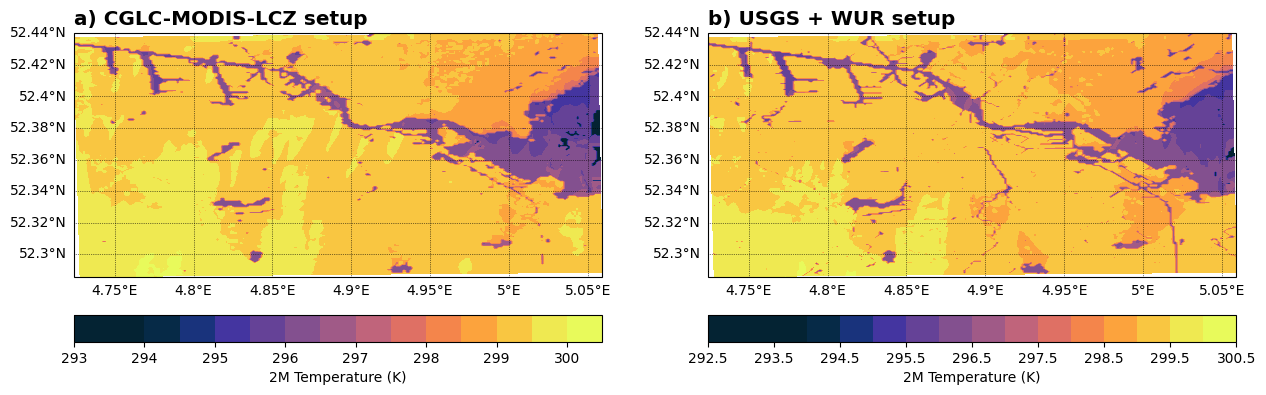

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.contourf(
    wur_lcz_T2.lon, wur_lcz_T2.lat, wur_lcz_T2, 16, vmin=294, vmax=300, cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ setup', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.1, label='2M Temperature (K)', ax=ax1)

ax2 = fig.add_subplot(1, 2, 2, projection=proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.contourf(
    wur_T2.lon, wur_T2.lat, wur_T2, 16, vmin=294, vmax=300, cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax2.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) USGS + WUR setup', **title_options)
cbar = fig.colorbar(ct2, orientation='horizontal', fraction=0.09, pad=0.1, label='2M Temperature (K)', ax=ax2)

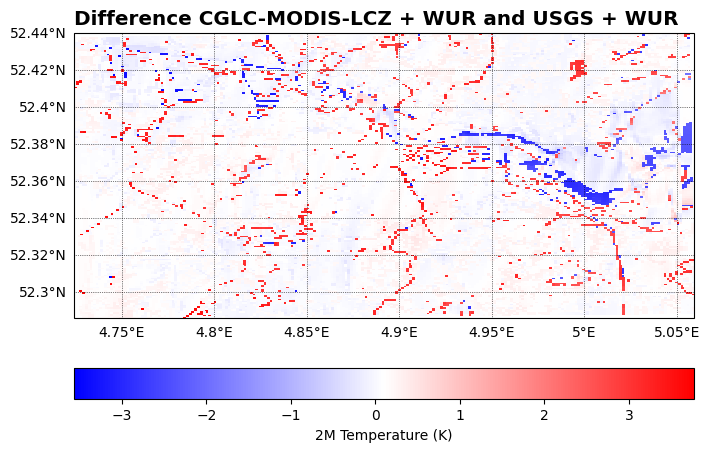

In [15]:
diff = wur_lcz_T2 - wur_T2

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    wur_T2.lon, wur_T2.lat, diff, cmap='bwr', transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('Difference CGLC-MODIS-LCZ + WUR and USGS + WUR', **title_options)
cbar = fig.colorbar(ct1, orientation='horizontal', fraction=0.09, pad=0.08, label='2M Temperature (K)', ax=ax1)

In [16]:

wur_lcz_file4 = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test')
wur_lcz_file1 = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test1')
wur_lcz_file2 = salem.open_wrf_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test2')

In [17]:
wur_lcz_T21 = wur_lcz_file1.T2.isel(time=1)
wur_lcz_T22 = wur_lcz_file2.T2.isel(time=1)
wur_lcz_T24 = wur_lcz_file4.T2.isel(time=3)

extent1 = [wur_lcz_T21.lon.min(), wur_lcz_T21.lon.max(), wur_lcz_T21.lat.min(), wur_lcz_T21.lat.max()]
extent2 = [wur_lcz_T22.lon.min(), wur_lcz_T22.lon.max(), wur_lcz_T22.lat.min(), wur_lcz_T22.lat.max()]
extent4 = [wur_lcz_T24.lon.min(), wur_lcz_T24.lon.max(), wur_lcz_T24.lat.min(), wur_lcz_T24.lat.max()]

wur_lcz_T24

<xarray.DataArray 'T2' (south_north: 165, west_east: 220)> Size: 145kB
[36300 values with dtype=float32]
Coordinates:
    lat          (south_north, west_east) float32 145kB 52.29 52.29 ... 52.44
    lon          (south_north, west_east) float32 145kB 4.728 4.73 ... 5.056
    xtime        datetime64[ns] 8B ...
    time         datetime64[ns] 8B 2019-07-23T09:00:00
  * west_east    (west_east) float64 2kB -8.411e+04 -8.401e+04 ... -6.221e+04
  * south_north  (south_north) float64 1kB 3.535e+04 3.545e+04 ... 5.175e+04
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:      
    pyproj_srs:   +proj=lcc +lat_0=51.9647178649902 +lon_0=6 +lat_1=30 +lat_2...

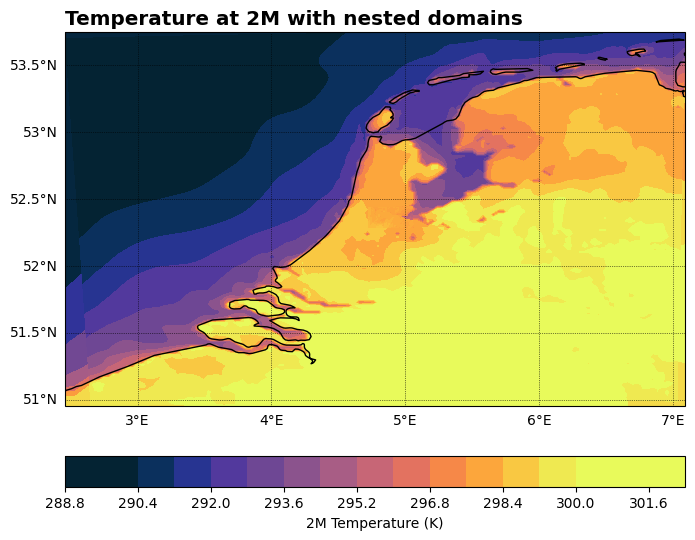

In [18]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent2)
ct1 = ax1.contourf(
    wur_lcz_T21.lon, wur_lcz_T21.lat, wur_lcz_T21, 20, cmap='cmo.thermal', vmin=290, vmax=300, transform=ccrs.PlateCarree()
)

ct2 = ax1.contourf(
    wur_lcz_T22.lon, wur_lcz_T22.lat, wur_lcz_T22, 20, cmap='cmo.thermal', vmin=290, vmax=300, transform=ccrs.PlateCarree()
)

ct3 = ax1.contourf(
    wur_lcz_T24.lon, wur_lcz_T24.lat, wur_lcz_T24, 20, cmap='cmo.thermal', vmin=290, vmax=300, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('Temperature at 2M with nested domains', **title_options)
cbar = fig.colorbar(ct2, orientation='horizontal', fraction=0.09, pad=0.08, label='2M Temperature (K)', ax=ax1)

In [19]:
from matplotlib.lines import Line2D

means = wur_lcz_var.mean(dim=("west_east","south_north"))
mins = wur_lcz_var.min(dim=("west_east","south_north"))
maxs = wur_lcz_var.max(dim=("west_east","south_north"))

means_wur = wur_var.mean(dim=("west_east","south_north"))
mins_wur = wur_var.min(dim=("west_east","south_north"))
maxs_wur = wur_var.max(dim=("west_east","south_north"))

means_modis = modis_var.mean(dim=("west_east","south_north"))
mins_modis = modis_var.min(dim=("west_east","south_north"))
maxs_modis = modis_var.max(dim=("west_east","south_north"))

means_usgs = usgs_var.mean(dim=("west_east","south_north"))
mins_usgs = usgs_var.min(dim=("west_east","south_north"))
maxs_usgs = usgs_var.max(dim=("west_east","south_north"))


In [28]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

for i in range(wur_lcz_var.shape[1]):
    for j in range(wur_lcz_var.shape[2]):
        ax2.plot(wur_lcz_var.time.values, wur_lcz_var[:, i, j], color='lightsteelblue', linewidth=0.1, alpha=0.2)
        ax2.plot(wur_var.time.values, wur_var[:, i, j], color='lightpink', linewidth=0.1, alpha=0.2)

lines2 = ax2.plot(means_wur.time.values, means_wur, linestyle='--', color='red', linewidth=2)
lines3 = ax2.plot(means.time.values, means, linestyle='--', color='blue', linewidth=2)

ax2.set_xlabel('Time')
ax2.set_ylabel('2M Temperature (K)')
plt.title('2M Temperature Time Series')

# Add legend
legend_elements = [Line2D([0], [0], linestyle='--', color='blue', lw=2, label='MODIS mean'),
                   Line2D([0], [0], linestyle='--', color='red', lw=2, label='WUR mean')]
ax2.legend(handles=legend_elements, loc='upper left')

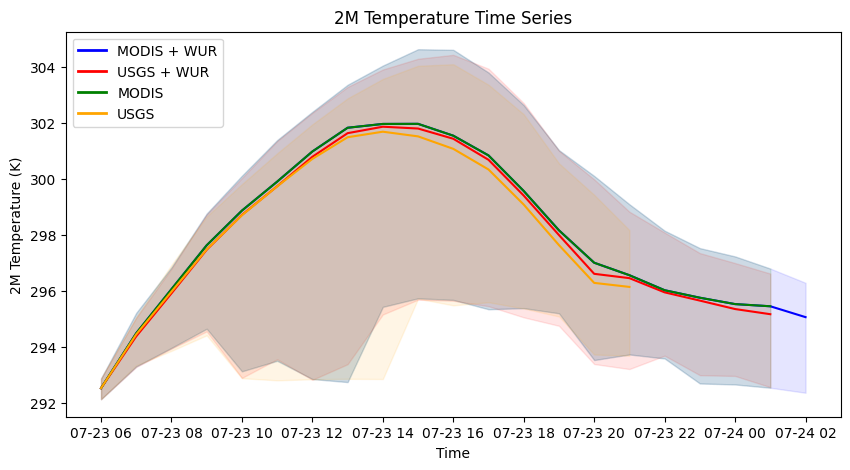

In [23]:
fig2, ax2 = plt.subplots(figsize=(10, 5))
lines = ax2.plot(means.time.values, means, linestyle='-', color='blue', linewidth=1.5)
ax2.fill_between(means.time.values, mins, maxs, alpha=0.1, color='blue')

lines = ax2.plot(means_wur.time.values, means_wur, linestyle='-', color='red', linewidth=1.5)
ax2.fill_between(means_wur.time.values, mins_wur, maxs_wur, alpha=0.1, color='red')

lines = ax2.plot(means_modis.time.values, means_modis, linestyle='-', color='green', linewidth=1.5)
ax2.fill_between(means_modis.time.values, mins_modis, maxs_modis, alpha=0.1, color='green')

lines = ax2.plot(means_usgs.time.values, means_usgs, linestyle='-', color='orange', linewidth=1.5)
ax2.fill_between(means_usgs.time.values, mins_usgs, maxs_usgs, alpha=0.1, color='orange')

ax2.set_xlabel('Time')
ax2.set_ylabel('2M Temperature (K)')
plt.title('2M Temperature Time Series')

# Add legend
legend_elements = [Line2D([0], [0], linestyle='-', color='blue', lw=2, label='MODIS + WUR'),
                   Line2D([0], [0], linestyle='-', color='red', lw=2, label='USGS + WUR'),
                   Line2D([0], [0], linestyle='-', color='green', lw=2, label='MODIS'),
                   Line2D([0], [0], linestyle='-', color='orange', lw=2, label='USGS')]
ax2.legend(handles=legend_elements, loc='upper left')